In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('omw-1.4')

import string
# Importing Gensim
import gensim
from gensim import corpora
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from wordcloud import WordCloud

import re



from pprint import pprint

import spacy

import pickle

import pyLDAvis
import pyLDAvis.gensim


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/midnights/Midnights.csv


/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [6]:
pip install pyldavis

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install gensim==3.8.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 46.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scattertext 0.1.7 requires gensim>=4.0.0, but you have gensim 3.8.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [8]:
midnights = pd.read_csv("/kaggle/input/midnights/Midnights.csv")

#dropped "Length", "Readability" & "Syllables Per Minute" for now!
midnights.drop(midnights.columns[[1,7,9]], axis=1, inplace=True)
midnights

,Song,Length (s),BPM,Key,Genre,Energy,Word Count
0,Lavender Haze,202,97,A♯/B♭,"R&B Soul, Pop",44,337
1,Maroon,218,108,G,Pop,40,350
2,Anti-Hero,201,97,E,Pop,64,332
3,Snow on the Beach,256,110,A,Pop,32,369
4,"You're on Your Own, Kid",194,120,D,Pop,40,293
5,Midnight Rain,175,140,C,"Electro Pop, R&B, Pop",36,279
6,Question...?,211,109,G,"Alternative/Indie, R&B/Soul, Pop, German Pop",50,407
7,Vigilante Shit,165,80,E,"Alternative/Indie, R&B/Soul, Pop, German Pop",28,261
8,Bejeweled,194,164,G,"Alternative/Indie, R&B/Soul, Pop, German Pop",56,428
9,Labyrinth,248,110,C,"Alternative/Indie, Pop",31,255


In [9]:
#a function that finds outliers
#input: dataframe
#output: dataframe with only outliers
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

<AxesSubplot:>

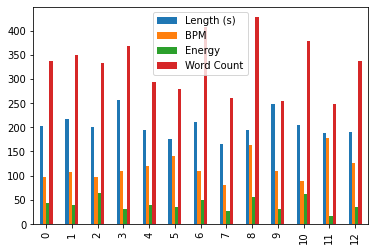

In [10]:
#all variables per song
#make this prettier later
midnights.plot.bar()

In [11]:
find_outliers_IQR(midnights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


,Song,Length (s),BPM,Key,Genre,Energy,Word Count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,256.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,248.0,NaN,NaN,NaN,NaN,NaN


**RESULTS**:
* outliers in length: Snow on the Beach, Labyrinth
* outliers in BPM: Sweet Nothing
* No other outliers

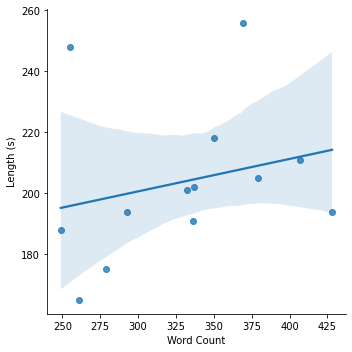

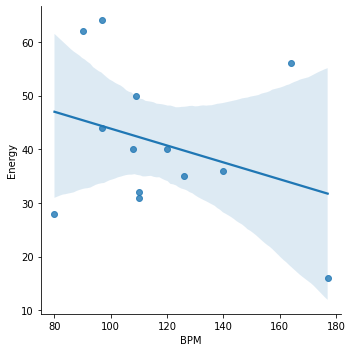

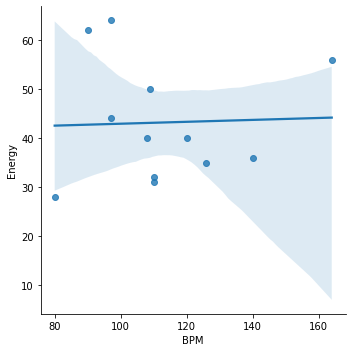

In [12]:
#regression lines

#words vs length
sns.lmplot(x='Word Count',y='Length (s)',data=midnights,fit_reg=True) 
#BPM vs energy
sns.lmplot(x='BPM',y='Energy',data=midnights,fit_reg=True) 
#without sweet nothing
sns.lmplot(x='BPM',y='Energy',data=midnights[midnights["Song"] != "Sweet Nothing"]
,fit_reg=True) 

--------------
**ANALYSIS:**
* overall positive correlation between word count and length in seconds, more words tend to have longer songs
* outliers Snow and Labyrinth are longer with less words, both are also second and third last in energy
* overall negative correlation between BPM and Energy surprisingly. More BPM led to less energy. However, Sweet Nothing had high outlier for BPM, and was lowest in energy, and was a big influential point. Getting rid of Sweet Nothing makes the correlation more of a constant slightly positive slope.

**==================== NLP ====================**

In [13]:
#stopwords predefined by nltk
stop_words = set(stopwords.words("english"))
morestops = ["oh", "much","comin","goin", "theyre","gonna", "howd", "ah", "til","still","ill","yeah","this","ever","ive", "im", "oh","ooh", "thats","gunna", "wanna", "like","get", "cause","it"]
for s in morestops:
    stop_words.add(s)

stop_words.remove("why")
print(stop_words)
#===========================================
exclude = set(string.punctuation)

lemmatizer = WordNetLemmatizer()


def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop_words])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    #print(punc_free)
    again = " ".join([i for i in punc_free.split() if i not in stop_words])
    #print(again)
    normalized = " ".join(lemmatizer.lemmatize(word) for word in again.split())
    return normalized

#notes:
#lemmatizing >>>>>> stemming
#lemmatizer.lemmatize("best", pos="a") returns "good"
#a = adj; tag everything?

{'where', 'a', 'doing', 'o', "isn't", 'herself', 'about', "weren't", 'by', 'is', 'all', 'mustn', 'the', 'isn', 'still', 'hers', 'been', 't', 'against', 'down', 'has', 'me', 'into', "needn't", 'haven', 'again', 'and', "you're", 'than', 'needn', 'cause', 'under', 'on', "haven't", 'gunna', 'd', 'himself', 'wanna', 'very', 'her', 'oh', 'out', "she's", 'im', 'during', 'having', 'until', 'because', 'yourself', 'didn', 'off', 'whom', "you've", 'your', "couldn't", 'over', "it's", 'ooh', 'no', "didn't", 'an', 'as', 'in', 'then', 'did', 'while', "mustn't", 'you', 'much', 'his', 'themselves', 'nor', 'll', 'weren', 'each', 'who', 'do', 'ive', 'does', "wouldn't", 'be', 'between', 'can', 'til', 'he', 'should', 'get', 'theirs', 'only', 'don', 've', 'any', 'ours', 'have', "won't", 'wasn', 'above', 'will', 're', "don't", 'i', 'this', "shan't", 'through', 'myself', 'they', 'which', "should've", 'had', "mightn't", 'if', 'before', 'other', "hasn't", 'or', 'ma', 'at', 'but', 'from', 'more', "aren't", 'your

In [14]:
lavenderhaze = """Meet me at midnight

Staring at the ceiling with you
Oh, you don't ever say too much
And you don't really read into
My melancholia

I been under scrutiny (Yeah, oh, yeah)
You handle it beautifully (Yeah, oh, yeah)
All this shit is new to me (Yeah, oh, yeah)
I feel the lavender haze creeping up on me
Surreal
I'm damned if I do give a damn what people say
No deal
The 1950s shit they want from me
I just wanna stay in that lavender haze

All they keep asking me (All they keep asking me)
Is if I'm gonna be your bride
The only kinda girl they see (Only kinda girl they see)
Is a one-night or a wife

I find it dizzying (Yeah, oh, yeah)
They're bringing up my history (Yeah, oh, yeah)
But you weren't even listening (Yeah, oh, yeah)

I feel the lavender haze creepin' up on me
Surreal
I'm damned if I do give a damn what people say
No deal
The 1950s shit they want from me
I just wanna stay in that lavender haze
That lavender haze

Talk your talk and go viral
I just need this love spiral
Get it off your chest
Get it off my desk (Get it off my desk)
Talk your talk and go viral
I just need this love spiral
Get it off your chest
Get it off my desk

I feel (I feel), the lavender haze creeping up on me
Surreal
I'm damned if I do give a damn what people say
No deal (No deal)
The 1950s shit they want from me
I just wanna stay in that lavender haze

Get it off your chest
Get it off my desk
That lavender haze
I just wanna stay
I just wanna stay in that lavender haze
"""
maroon = """When the morning came
We were cleaning incense off your vinyl shelf
'Cause we lost track of time again
Laughing with my feet in your lap
Like you were my closest friend
"How'd we end up on the floor, anyway?" you say
"Your roommate's cheap-ass screw-top rosé, that's how"
I see you every day now

And I chose you
The one I was dancing with
In New York, no shoes
Looked up at the sky and it was
The burgundy on my t-shirt
When you splashed your wine into me
And how the blood rushed into my cheeks
So scarlet, it was
The mark thеy saw on my collarbone
The rust that grew bеtween telephones
The lips I used to call home
So scarlet, it was maroon
When the silence came
We were shaking, blind and hazy
How the hell did we lose sight of us again?
Sobbing with your head in your hands
Ain't that the way shit always ends?
You were standing hollow-eyed in the hallway
Carnations you had thought were roses, that's us
I feel you, no matter what
The rubies that I gave up

And I lost you
The one I was dancing with
In New York, no shoes
Looked up at the sky and it was (Maroon)
The burgundy on my t-shirt
When you splashed your wine into me
And how the blood rushed into my cheeks
So scarlet, it was (Maroon)
The mark they saw on my collarbone
The rust that grew between telephones
The lips I used to call home
So scarlet, it was maroon

And I wake with your memory over me
That's a real fucking legacy, legacy (It was maroon)
And I wake with your memory over me
That's a real fucking legacy to leave

The burgundy on my t-shirt
When you splashed your wine into me
And how the blood rushed into my cheeks
So scarlet, it was maroon
The mark they saw on my collarbone
The rust that grew between telephones
The lips I used to call home
So scarlet, it was maroon

It was maroon
It was maroon
"""
antihero = """I have this thing where I get older, but just never wiser
Midnights become my afternoons
When my depression works the graveyard shift, all of the people
I've ghosted stand there in the room

I should not be left to my own devices
They come with prices and vices
I end up in crisis
(Tale as old as time)
I wake up screaming from dreaming
One day, I'll watch as you're leaving
'Cause you got tired of my scheming
(For the last time)
It's me, hi
I'm the problem, it's me
At teatime, everybody agrees
I'll stare directly at the sun, but never in the mirror
It must be exhausting always rooting for the anti-hero

Sometimes, I feel like everybody is a sexy baby
And I'm a monster on the hill
Too big to hang out, slowly lurching toward your favorite city
Pierced through the heart, but never killed

Did you hear my covert narcissism I disguise as altruism
Like some kind of congressman?
(A tale as old as time)
I wake up screaming from dreaming
One day, I'll watch as you're leaving
And life will lose all its meaning
(For the last time)

It's me, hi
I'm the problem, it's me (I'm the problem, it's me)
At teatime, everybody agrees
I'll stare directly at the sun, but never in the mirror
It must be exhausting always rooting for the anti-hero

I have this dream my daughter-in-law kills me for the money
She thinks I left them in the will
The family gathers 'round and reads it and then someone screams out
"She's laughing up at us from Hell"

It's me, hi
I'm the problem, it's me
It's me, hi
I'm the problem, it's me
It's me, hi
Everybody agrees, everybody agrees

It's me, hi (Hi)
I'm the problem, it's me (I'm the problem, it's me)
At teatime (Teatime), everybody agrees (Everybody agrees)
I'll stare directly at the sun, but never in the mirror
It must be exhausting always rooting for the anti-hero
"""
snowonthebeach = """One night, a few moons ago
I saw flecks of what could've been lights
But it might just have been you
Passing by unbeknownst to me
Life is emotionally abusive
And time can't stop me quite like you did
And my flight was awful, thanks for asking
I'm unglued, thanks to you

And it's like snow at the beach
Weird, but fuckin' beautiful
Flying in a dream
Stars by the pocketful
You wanting me
Tonight feels impossible
But it's comin' down
No sound, it's all around
Like snow on the beach
Like snow on the beach
Like snow on the beach
Like snow, ah

This scene feels like what I once saw on a screen
I searched "aurora borealis green"
I've never seen someone lit from within
Blurring out my periphery
My smile is like I won a contest
And to hide that would be so dishonest
And it's fine to fake it 'til you make it
'Til you do, 'til it's true

Now it's like snow at the beach
Weird, but fuckin' beautiful
Flying in a dream
Stars by the pocketful
You wanting me
Tonight feels impossible
But it's comin' down
No sound, it's all around

Like snow on the beach
Like snow on the beach
Like snow on the beach
Like snow, ah

I (I) can't (Can't) speak, afraid to jinx it
I (I) don't (Don't) even dare to wish it
But your eyes are flying saucers from another planet
Now I'm all for you like Janet
Can this be a real thing? Can it?

Are we falling like snow at the beach? (Snow at the beach)
Weird, but fuckin' beautiful
Flying in a dream (Flying in a dream)
Stars by the pocketful
You wanting me (You wanting me)
Tonight feels impossible
But it's comin' down
No sound, it's all around

Like snow on the beach (Snow on the beach)
Like snow on the beach (Flying in a dream)
Like snow on the beach (You wanting me)
Like snow, ah
But it's comin' down
No sound, it's all around
Like snow on the beach
(It's comin' down, it's comin' down)
(It's comin' down, it's comin' down)
Like snow on the beach
(It's comin' down, it's comin' down)
(It's comin' down, it's comin' down)
(It's comin' down, it's comin' down)
(It's comin' down, it's comin' down)
(It's comin' down, it's comin' down)
(It's comin' down, it's comin' down)
"""
yoyok = """Summer went away, still, the yearning stays
I play it cool with the best of them
I wait patiently, he's gonna notice me
It's okay, we're the best of friends
Anyway
I hear it in your voice, you're smoking with your boys
I touch my phone as if it's your face
I didn't choose this town, I dream of getting out
There's just one who could make me stay
All my days
From sprinkler splashes to fireplace ashes
I waited ages to see you there
I search the party of better bodies
Just to learn that you never cared

You're on your own, kid
You always have been

I see the great escape, so long, Daisy May
I picked the petals, he loves me not
Something different bloomed, writing in my room
I play my songs in the parking lot
I'll run away

From sprinkler splashes to fireplace ashes
I called a taxi to take me there
I search the party of better bodies
Just to learn that my dreams aren't rare

You're on your own, kid
You always have been

From sprinkler splashes to fireplace ashes
I gave my blood, sweat, and tears for this
I hosted parties and starved my body
Like I'd be saved by a perfect kiss
The jokes weren't funny, I took the money
My friends from home don't know what to say
I looked around in a blood-soaked gown
And I saw something they can't take away
'Cause there were pages turned with the bridges burned
Everything you lose is a step you take
So, make the friendship bracelets, take the moment and taste it
You've got no reason to be afraid

You're on your own, kid
Yeah, you can face this
You're on your own, kid
You always have been
"""
midnightrain = """Rain
He wanted it comfortable, I wanted that pain
He wanted a bride, I was making my own name
Chasing that fame, he stayed the same
All of me changed like midnight

My town was a wasteland
Full of cages, full of fences
Pageant queens and big pretenders
But for some, it was paradise
My boy was a montage
A slow-motion, love potion
Jumping off things in the ocean
I broke his heart 'cause he was nice
He was sunshine, I was midnight rain
He wanted it comfortable, I wanted that pain
He wanted a bride, I was making my own name
Chasing that fame, he stayed the same
All of me changed like midnight

It came like a postcard
Picture perfect shiny family
Holiday peppermint candy
But for him, it's every day
So I peered through a window
A deep portal, time travel
All the love we unravel
And the life I gave away
'Cause he was sunshine, I was midnight rain

He wanted it comfortable, I wanted that pain
He wanted a bride, I was making my own name
Chasing that fame, he stayed the same
All of me changed like midnight rain
He wanted it comfortable, I wanted that pain
He wanted a bride, I was making my own name
Chasing that fame, he stayed the same
All of me changed like midnight

I guess sometimes we all get
Just what we wanted, just what we wanted
And he never thinks of me
Except for when I'm on TV
I guess sometimes we all get
Some kind of haunted, some kind of haunted
And I never think of him
Except on midnights like this
(Midnights like this, midnights like this)
"""
question = """I remember

Good girl, sad boy
Big city, wrong choices
We had one thing goin' on
I swear that it was somethin'
'Cause I don't remember who I was
Before you painted all my nights
A color I've searched for since
But one thing after another
Fuckin' situations, circumstances
Miscommunications and I
Have to say, by the way
I just may like some explanations
Can I ask you a question?
Did you ever have someone kiss you in a crowded room
And every single one of your friends was makin' fun of you
But fifteen seconds later, thеy were clappin' too?
Then what did you do?
Did you lеave her house in the middle of the night? Oh
Did you wish you'd put up more of a fight, oh
When she said it was too much?
Do you wish you could still touch her?
It's just a question

Half-moon eyes, bad surprise
Did you realize out of time?
She was on your mind with some dickhead guy
That you saw that night
But you were on somethin'
It was one drink after another
Fuckin' politics and gender roles
And you're not sure and I don't know
Got swept away in the gray
I just may like to have a conversation

Can I ask you a question?
Did you ever have someone kiss you in a crowded room
And every single one of your friends was makin' fun of you
But fifteen seconds later, they were clappin' too?
Then what did you do?
Did you leave her house in the middle of the night? Oh
Did you wish you'd put up more of a fight, oh
When she said it was too much?
Do you wish you could still touch her?

Does it feel like everything's just like
Second best after that meteor strike?
And what's that that I heard? That you're still with her?
That's nice, I'm sure that's what's suitable
And right, but tonight

Can I ask you a question? (Can I ask you a question?)
Did you ever have someone kiss you in a crowded room (In a crowded room)
And every single one of your friends was makin' fun of you (Makin' fun of you)
But fifteen seconds later, they were clappin' too?
Then what did you do? (Do)
Did you leave her house in the middle of the night? Oh
Did you wish you'd put up more of a fight, oh (More of a fight)
When she said it was too much?
Do you wish you could still touch her?
It's just a question
"""
vigilanteshit = """Draw the cat eye sharp enough to kill a man
You did some bad things, but I'm the worst of them
Sometimes I wonder which one'll be your last lie
They say looks can kill and I might try
I don't dress for women
I don't dress for men
Lately, I've been dressin' for revenge

I don't start shit, but I can tell you how it ends
Don't get sad, get even
So on the weekends
I don't dress for friends
Lately, I've been dressin' for revenge
She needed cold, hard proof, so I gave her some
She had the envelope, where you think she got it from?
Now she gets the house, gets the kids, gets the pride
Picture me thick as thieves with your ex-wife
And she looks so pretty
Drivin' in your Benz
Lately, she's been dressin' for revenge

She don't start shit, but she can tell you how it ends
Don't get sad, get even
So on the weekends
She don't dress for friends
Lately, she's been dressing for revenge

Ladies always rise above
Ladies know what people want
Someone sweet and kind and fun
The lady simply had enough

While he was doin' lines and crossin' all of mine
Someone told his white-collar crimes to the FBI
And I don't dress for villains
Or for innocents
I'm on my vigilante shit again

I don't start shit, but I can tell you how it ends
Don't get sad, get even
So on the weekends
I don't dress for friends
Lately, I've been dressin' for revenge
"""
bejeweled = """Baby love, I think I've been a little too kind
Didn't notice you walkin' all over my peace of mind
In the shoes I gave you as a present
Puttin' someone first only works when you're in their top five
And by the way, I'm goin' out tonight

Best believe I'm still bejeweled
When I walk in the room
I can still make the whole place shimmer
And when I meet the band
They ask, "Do you have a man?"
I could still say, "I don't remember"
Familiarity breeds contempt
Don't put mе in the basement
Whеn I want the penthouse of your heart
Diamonds in my eyes
I polish up real, I polish up real nice
Nice

Baby boy, I think I've been too good of a girl (Too good of a girl)
Did all the extra credit, then got graded on a curve
I think it's time to teach some lessons
I made you my world (Huh), have you heard? (Huh)
I can reclaim the land
And I miss you (Miss you)
But I miss sparklin' (Nice)

Best believe I'm still bejeweled
When I walk in the room
I can still make the whole place shimmer
And when I meet the band
They ask, "Do you have a man?"
I could still say, "I don't remember"
Familiarity breeds contempt
Don't put me in the basement
When I want the penthouse of your heart
Diamonds in my eyes
I polish up real, I polish up real nice

Nice

Sapphire tears on my face
Sadness became my whole sky
But some guy said my aura's moonstone
Just 'cause he was high
And we're dancin' all night
And you can try to change my mind
But you might have to wait in line
What's a girl gonna do?
A diamond's gotta shine

Best believe I'm still bejeweled
When I walk in the room
I can still make the whole place shimmer (Shimmer)
And when I meet the band
They ask, "Do you have a man?"
I could still say, "I don't remember"
Familiarity breeds contempt
Don't put me in the basement
When I want the penthouse of your heart
Diamonds in my eyes
I polish up real (Nice), I polish up real nice

And we're dancin' all night
And you can try to change my mind
But you might have to wait in line
What's a girl gonna do? What's a girl gonna do?
I polish up nice
Best believe I'm still bejeweled
When I walk in the room
I can still make the whole place shimmer
"""
labyrinth = """"It only hurts this much right now"
Was what I was thinkin' the whole time
Breathe in, breathe through, breathe deep, breathe out
I'll be gettin' over you my whole life

You know how scared I am of elevators
Never trust it if it rises fast
It can't last
Uh-oh, I'm fallin' in love
Oh no, I'm fallin' in love again
Oh, I'm fallin' in love
I thought the plane was goin' down
How'd you turn it right around?

It only feels this raw right now
Lost in the labyrinth of my mind
Break up, break free, break through, break down
You would break your back to make me break a smile

You know how much I hate
That everybody just expects me to bounce back
Just like that

Uh-oh, I'm fallin' in love
Oh no, I'm fallin' in love again
Oh, I'm fallin' in love
I thought the plane was goin' down
How'd you turn it right around?
Uh-oh, I'm fallin' in love
Oh no, I'm fallin' in love again
Oh, I'm fallin' in love
I thought the plane was goin' down
How'd you turn it right around?
Uh-oh, I'm fallin' in love
Oh no, I'm fallin' in love again
Oh, I'm fallin' in love
I thought the plane was goin' down
How'd you turn it right around?
Uh-oh, I'm fallin' in love
Oh no, I'm fallin' in love again
Oh, I'm fallin' in love
I thought the plane was goin' down
How'd you turn it right around?
"""
karma = """You're talking shit for the hell of it
Addicted to betrayal, but you're relevant
You're terrified to look down
'Cause if you dare, you'll see the glare
Of everyone you burned just to get there
It's coming back around

And I keep my side of the street clean
You wouldn't know what I mean
'Cause karma is my boyfriend
Karma is a god
Karma is the breeze in my hair on the weekend
Karma's a relaxing thought
Aren't you envious that for you it's not?
Sweet like honey, karma is a cat
Purring in my lap 'cause it loves me
Flexing like a goddamn acrobat
Me and karma vibe like that

Spiderboy, king of thieves
Weave your little webs of opacity
My pennies made your crown
Trick me once, trick me twice
Don't you know that cash ain't the only price?
It's coming back around

And I keep my side of the street clean
You wouldn't know what I mean

'Cause karma is my boyfriend
Karma is a god
Karma is the breeze in my hair on the weekend
Karma's a relaxing thought
Aren't you envious that for you it's not?
Sweet like honey, karma is a cat
Purring in my lap 'cause it loves me
Flexing like a goddamn acrobat
Me and karma vibe like that

Ask me what I learned from all those years
Ask me what I earned from all those tears
Ask me why so many fade, but I'm still here
(I'm still here, I'm still here)

'Cause karma is the thunder
Rattling your ground
Karma's on your scent like a bounty hunter
Karma's gonna track you down
Step by step, from town to town
Sweet like justice, karma is a queen
Karma takes all my friends to the summit
Karma is the guy on the screen
Coming straight home to me

'Cause karma is my boyfriend (Karma is my boyfriend)
Karma is a god
Karma is the breeze in my hair on the weekend (Weekend)
Karma's a relaxing thought
Aren't you envious that for you it's not?
Sweet like honey, karma is a cat
Purring in my lap 'cause it loves me
Flexing like a goddamn acrobat
Me and karma vibe like that
Karma is my boyfriend
Karma is a god (Ah)
Uh-huh, mm
Karma's a relaxing thought
"""
sweetnothing = """I spy with my little tired eye
Tiny as a firefly
A pebble that we picked up last July
Down deep inside your pocket
We almost forgot it
Does it ever miss Wicklow sometimes?
Ooh, ooh

They said the end is comin'
Everyone’s up to somethin'
I find myself runnin' home to your sweet nothings
Outside, they’re push and shovin'
You're in the kitchen hummin'
All that you ever wanted from me was sweet nothin'
On the way home
I wrote a poem
You say, "What a mind"
This happens all the time
Ooh, ooh

'Causе they said the end is comin'
Evеryone's up to somethin’
I find myself runnin’ home to your sweet nothings
Outside, they're push and shovin’
You're in the kitchen hummin'
All that you ever wanted from me was nothin'

Industry disruptors and soul deconstructors
And smooth-talking hucksters out glad-handing each other
And the voices that implore, "You should be doing more"
To you, I can admit that I’m just too soft for all of it
Ooh

They said the end is comin'
Everyone's up to somethin'
I find myself runnin' home to your sweet nothings
Outside, they're push and shovin'
You're in the kitchen hummin'
All that you ever wanted from me was sweet nothin'
They said the end is comin' (They said the end is comin')
Everyone's up to somethin' (Everyone's up to somethin')
I find myself runnin' home to your sweet nothings
Outside, they're push and shovin' (Outside, they're push and shovin')
You're in the kitchen hummin' (You're in the kitchen hummin')
All that you ever wanted from me was sweet nothin'
"""
mastermind = """Once upon a time, the planets and the fates
And all the stars aligned
You and I ended up in the same room
At the same time

And the touch of a hand lit the fuse
Of a chain reaction of countermoves
To assess the equation of you
Checkmate, I couldn't lose
What if I told you none of it was accidental?
And the first night that you saw me
Nothing was gonna stop me
I laid the groundwork, and then
Just like clockwork
The dominoes cascaded in a line
What if I told you I'm a mastermind?
And now you're mine
It was all by dеsign
'Cause I'm a mastermind

You see, all the wisеst women
Had to do it this way
'Cause we were born to be the pawn
In every lover's game

If you fail to plan, you plan to fail
Strategy sets the scene for the tale
I'm the wind in our free-flowing sails
And the liquor in our cocktails

What if I told you none of it was accidental?
And the first night that you saw me
I knew I wanted your body
I laid the groundwork, and then
Just like clockwork
The dominoes cascaded in a line
What if I told you I'm a mastermind?
And now you're mine
It was all my design
'Cause I'm a mastermind

No one wanted to play with me as a little kid
So I've been scheming like a criminal ever since
To make them love me and make it seem effortless
This is the first time I've felt the need to confess
And I swear
I'm only cryptic and Machiavellian
'Cause I care

So I told you none of it was accidental
And the first night that you saw me
Nothing was gonna stop me
I laid the groundwork, and then
Saw a wide smirk on your face
You knew the entire time
You knew that I'm a mastermind
And now you're mine
Yeah, all you did was smile
'Cause I'm a mastermind
"""


In [15]:
lyrics = [lavenderhaze, maroon, antihero, snowonthebeach, yoyok, midnightrain, question, vigilanteshit, bejeweled, labyrinth, karma, sweetnothing, mastermind]
lyrics_cleaned = [clean(song).split() for song in lyrics]
#print(lyrics_cleaned)

# Creating the term dictionary of our courpus, 
#where every unique term is assigned an index. 
dictionary = corpora.Dictionary(lyrics_cleaned)

# Converting list of documents (corpus) into Document Term Matrix 
#using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in lyrics_cleaned]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.018*"wanted" + 0.009*"night" + 0.009*"nice"'), (1, '0.040*"karma" + 0.027*"snow" + 0.023*"beach"'), (2, '0.026*"love" + 0.022*"fallin" + 0.013*"haze"')]


> **============= pyldavis ==============**

In [16]:
print(doc_term_matrix[:1])
[[(dictionary[i], freq) for i, freq in doc] for doc in doc_term_matrix[:1]]
# Build LDA model
lda_model = LdaModel(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=10,
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]
#corpus: doc_term_matrix
#dictionary/id2word: dictionary

[[(0, 3), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 2), (9, 3), (10, 3), (11, 4), (12, 4), (13, 1), (14, 1), (15, 4), (16, 1), (17, 2), (18, 3), (19, 2), (20, 1), (21, 9), (22, 1), (23, 2), (24, 2), (25, 9), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 3), (35, 1), (36, 1), (37, 4), (38, 1), (39, 2), (40, 4), (41, 2), (42, 1), (43, 5), (44, 3), (45, 4), (46, 2), (47, 3), (48, 1)]]
[(0,
  '0.011*"dress" + 0.010*"shit" + 0.010*"revenge" + 0.010*"friend" + '
  '0.009*"mastermind" + 0.009*"told" + 0.009*"make" + 0.008*"dressin" + '
  '0.008*"lately" + 0.007*"saw"'),
 (1,
  '0.016*"fallin" + 0.012*"love" + 0.011*"maroon" + 0.010*"dress" + '
  '0.008*"problem" + 0.008*"hi" + 0.008*"lately" + 0.008*"end" + '
  '0.008*"everybody" + 0.008*"thought"'),
 (2,
  '0.015*"hi" + 0.011*"problem" + 0.011*"agrees" + 0.010*"everybody" + '
  '0.009*"never" + 0.008*"time" + 0.007*"teatime" + 0.007*"always" + '
  '0.007*"must" + 0.007*"antihero"'),
 (3,
  '0.

In [17]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary=dictionary)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.144580 -0.077878       1        1  26.867046
0      0.017117  0.047413       2        1  13.222957
6     -0.137527 -0.050101       3        1  11.549352
4      0.022294  0.066598       4        1  10.756582
1     -0.004637 -0.065210       5        1  10.309962
5      0.053013  0.032245       6        1   8.004011
7     -0.098714  0.003132       7        1   6.441688
3     -0.013875  0.065180       8        1   4.475926
9      0.045064  0.009544       9        1   4.207696
2     -0.027315 -0.030925      10        1   4.164779, topic_info=        Term       Freq      Total Category  logprob  loglift
582    karma  19.000000  19.000000  Default  30.0000  30.0000
254     snow  16.000000  16.000000  Default  29.0000  29.0000
388   wanted  16.000000  16.000000  Default  28.0000  28.0000
213    beach  13.000000  13.000000  Default  27.0000  27.0000
479    sweet   9.000000   9.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
92    maroon   0.475557   7.606630  Topic10  -5.0697   0.4062
66       day   0.328305   4.345987  Topic10  -5.4402   0.5954
105  scarlet   0.348783   5.263841  Topic10  -5.3797   0.4643
96       one   0.408994   9.045495  Topic10  -5.2205   0.0822
164     last   0.316615   4.592643  Topic10  -5.4765   0.5040

[520 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
652       1  0.328192  accidental
652       2  0.328192  accidental
559       3  0.745702     acrobat
560       3  0.742460    addicted
130       3  0.200219      agrees
...     ...       ...         ...
266       6  0.210548        wish
266       8  0.210548        wish
266       9  0.210548        wish
489       2  0.434779       woman
490       2  0.644592      wonder

[565 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 7, 5, 2, 6, 8, 4, 10, 3])